**Imports & Load the dataset**

In [42]:
# Import necessary libraries for data manipulation, visualization, and machine learning
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, KFold, cross_val_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.datasets import make_classification
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.text import Tokenizer
import string
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from collections import Counter
from google.colab import drive

# Download stopwords if not already done
import nltk
nltk.download('punkt')
nltk.download('stopwords')

drive.mount('/content/drive')

# Load the dataset
file_path = '/content/drive/MyDrive/11.csv'
df = pd.read_csv(file_path)

# Display the first few rows of the dataset
df = df.iloc[:, 1:]  # Remove the first column as it duplicates index
print("First few rows of the dataset:")
df.head()


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
First few rows of the dataset:


,category,headline,authors,link,short_description,date
0,ENTERTAINMENT,Justin Timberlake & David Fincher: 'The Social...,Madeline Boardman,https://www.huffingtonpost.com/entry/justin-ti...,[via The Playlist] It was announced this week ...,2013-02-02
1,GREEN,"Goodbye, Bear","Alessandra Macaluso, ContributorAuthor, Freela...",https://www.huffingtonpost.com/entry/goodbye-b...,I know there's a big wide world spinning aroun...,2014-12-01
2,GREEN,Hurricane Matthew's Strength Is Yet Another Cl...,Lydia O'Connor,https://www.huffingtonpost.com/entry/hurricane...,It's unusual for a storm like this to hit in O...,2016-10-05
3,ENTERTAINMENT,David Bowie's Son Welcomes Baby Boy Exactly Si...,Cole Delbyck,https://www.huffingtonpost.com/entry/david-bow...,"""His granddad made room for him.""",2016-07-30
4,ENTERTAINMENT,"Wow, 'Transparent' Is Simply A Great Show",Maureen Ryan,https://www.huffingtonpost.com/entry/transpare...,NaN,2014-09-25


**Data Exploration**

In [3]:
# Check for missing values and remove rows with missing values
print("Missing values before removal:")
print(df.isnull().sum())
df = df.dropna()
print("Missing values after removal:")
print(df.isnull().sum())

# Check the shape of the dataframe
df.shape

Missing values before removal:
category               20
headline               22
authors              1149
link                   14
short_description    1387
date                   12
dtype: int64
Missing values after removal:
category             0
headline             0
authors              0
link                 0
short_description    0
date                 0
dtype: int64


(5757, 6)

**Add description length as a feature**

In [4]:
df['description_length'] = df['short_description'].apply(lambda x: len(word_tokenize(x)))

# Identify and remove outliers in description length
description_length_mean = df['description_length'].mean()
description_length_std = df['description_length'].std()
outliers = df[df['description_length'] > description_length_mean + 3 * description_length_std]
print(f"Number of outliers identified: {len(outliers)}")
df = df[df['description_length'] <= description_length_mean + 3 * description_length_std]


Number of outliers identified: 48


In [5]:
# Function to preprocess text
def preprocess_text(text):
    text = text.lower()  # Lowercase the text
    text = text.translate(str.maketrans('', '', string.punctuation))  # Remove punctuation
    words = word_tokenize(text)  # Tokenize the text
    words = [word for word in words if word not in stopwords.words('english')]  # Remove stopwords
    return words


In [6]:
def analyze_common_terms(df):
    category_terms = {}
    for category in df['category'].unique():
        category_text = ' '.join(df[df['category'] == category]['short_description'].dropna())
        # Remove punctuation and symbols
        processed_words = [word.lower() for word in category_text.split() if word not in string.punctuation]
        category_terms[category] = Counter(processed_words).most_common(10)
    return category_terms

category_terms = analyze_common_terms(df)
print("Most common terms per category:")
print(category_terms)


Most common terms per category:
{'ENTERTAINMENT': [('the', 3541), ('a', 1562), ('to', 1355), ('and', 1297), ('of', 1264), ('in', 953), ('is', 794), ('for', 592), ('on', 574), ('that', 479)], 'GREEN': [('the', 1812), ('to', 909), ('of', 847), ('and', 809), ('a', 729), ('in', 540), ('is', 426), ('that', 318), ('for', 300), ('are', 238)]}


Sentence length statistics by category:
                count        mean        std  min   25%    50%    75%    max
category                                                                    
ENTERTAINMENT  4481.0   80.100870  63.431910  1.0  35.0   62.0  107.0  340.0
GREEN          1228.0  151.168567  80.191367  4.0  85.0  125.0  218.0  374.0


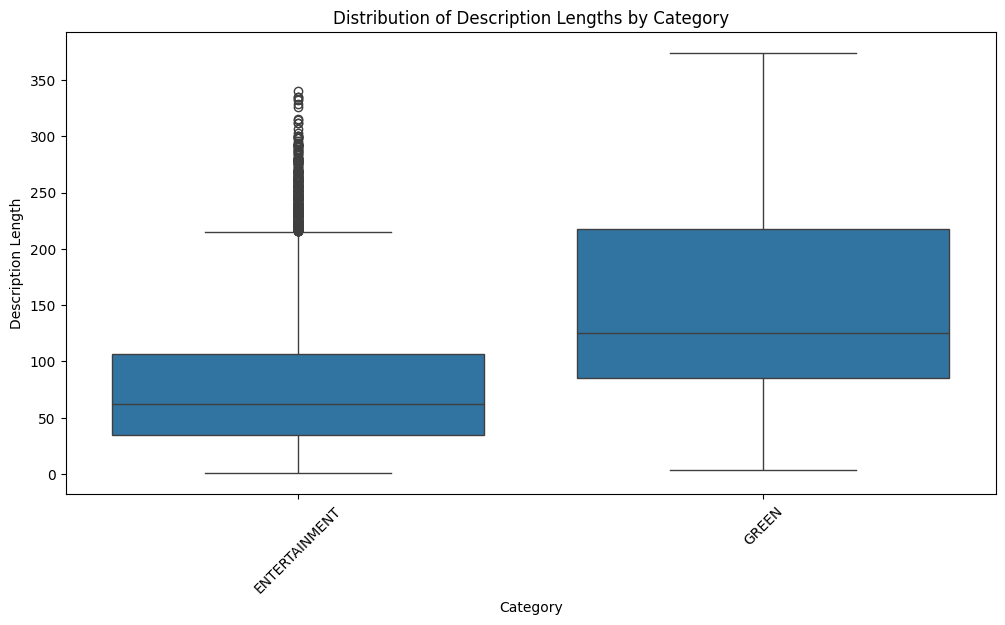

In [7]:
def analyze_sentence_length(df):
    # Handle missing values before calculating length
    df['description_length'] = df['short_description'].fillna('').apply(len)  # Replace NaN with empty string

    sentence_length_stats = df.groupby('category')['description_length'].describe()
    print("Sentence length statistics by category:")
    print(sentence_length_stats)

    plt.figure(figsize=(12, 6))
    sns.boxplot(x='category', y='description_length', data=df)
    plt.title('Distribution of Description Lengths by Category')
    plt.xlabel('Category')
    plt.ylabel('Description Length')
    plt.xticks(rotation=45)
    plt.show()

analyze_sentence_length(df)



**1.   Category Comparison:** The 'GREEN' category tends to have longer descriptions on average compared to 'ENTERTAINMENT'.

**2.   Variability:** Descriptions in the 'GREEN' category also exhibit greater variability (higher std) in their lengths compared to 'ENTERTAINMENT'.

**3.  Outliers:** The boxplot would visually identify outliers in each category, showing extreme values beyond the quartiles.List item





**Split dataset into training, validation, and test sets**

For splitting the dataset, we'll divide it into training, validation (development), and test sets. The test set will be used only for the final evaluation and not for parameter tuning.

In [8]:
# Split the dataset into training, validation, and test sets
train_val, test = train_test_split(df, test_size=0.15, random_state=42)
train, val = train_test_split(train_val, test_size=0.1765, random_state=42)  # 0.1765 * 0.85 = 0.15
train.to_csv('train.csv', index=False)
val.to_csv('valid.csv', index=False)
test.to_csv('test.csv', index=False)


**Preprocess the text data**

Now, let's preprocess the text data and vectorize it using TF-IDF (Term Frequency-Inverse Document Frequency), which is suitable for classification tasks. We'll also encode the labels.

In [9]:
def preprocess_text(text):
    if isinstance(text, str):  # Check if the text is a string
        text = text.lower()  # Lowercase the text
        text = text.translate(str.maketrans('', '', string.punctuation))  # Remove punctuation
        words = word_tokenize(text)  # Tokenize the text
        words = [word for word in words if word not in stopwords.words('english')]  # Remove stopwords
        return words
    else:
        return []  # Return an empty list if not a string

def preprocess_df(df):
    df['processed_description'] = df['short_description'].apply(preprocess_text).apply(' '.join)  # Preprocess the text data
    return df



train = preprocess_df(train)
val = preprocess_df(val)
test = preprocess_df(test)

# Vectorize the text data
vectorizer = TfidfVectorizer()
X_train = vectorizer.fit_transform(train['processed_description'])
X_val = vectorizer.transform(val['processed_description'])
X_test = vectorizer.transform(test['processed_description'])

# Encode the labels
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(train['category'])
y_val_encoded = label_encoder.transform(val['category'])
y_test_encoded = label_encoder.transform(test['category'])


Text preprocessing for classification involves essential steps like lowercasing, which ensures uniformity in word representation by converting all text to lowercase. Punctuation removal eliminates non-semantic symbols such as commas and periods, reducing noise. Stopwords removal filters out common words that add little value to classification tasks. TF-IDF vectorization converts text into numerical features that emphasize important words relative to the dataset, enhancing model performance by highlighting key terms crucial for accurate classification.

**Binary Classification Models**

In [12]:
# Initialize classifiers
knn = KNeighborsClassifier(n_neighbors=5)
logreg = LogisticRegression(max_iter=1000)



Choosing classifiers like Logistic Regression or K-Nearest Neighbors (KNN) depends on:

**K-Nearest Neighbors (KNN):**
For the KNN classifier, n_neighbors=5 was selected. KNN is advantageous for its simplicity and intuitive approach to classification. It makes predictions based on the majority class of its nearest neighbors in the feature space. The choice of n_neighbors=5 strikes a balance between bias and variance by considering a reasonable number of neighbors without overfitting to noise.

**Logistic Regression:**
Logistic Regression was chosen with max_iter=1000. This classifier is well-suited for binary classification tasks where the relationship between features and the target variable can be captured linearly. max_iter=1000 ensures that the optimization algorithm has sufficient iterations to converge to a solution, especially important for datasets where convergence may require more iterations due to complex relationships or larger feature sets.

In [13]:
# Train and evaluate KNN
knn.fit(X_train, y_train_encoded)
knn_accuracy_train = accuracy_score(y_train_encoded, knn.predict(X_train))
knn_accuracy_val = accuracy_score(y_val_encoded, knn.predict(X_val))


In [14]:
# Train and evaluate Logistic Regression
logreg.fit(X_train, y_train_encoded)
logreg_accuracy_train = accuracy_score(y_train_encoded, logreg.predict(X_train))
logreg_accuracy_val = accuracy_score(y_val_encoded, logreg.predict(X_val))


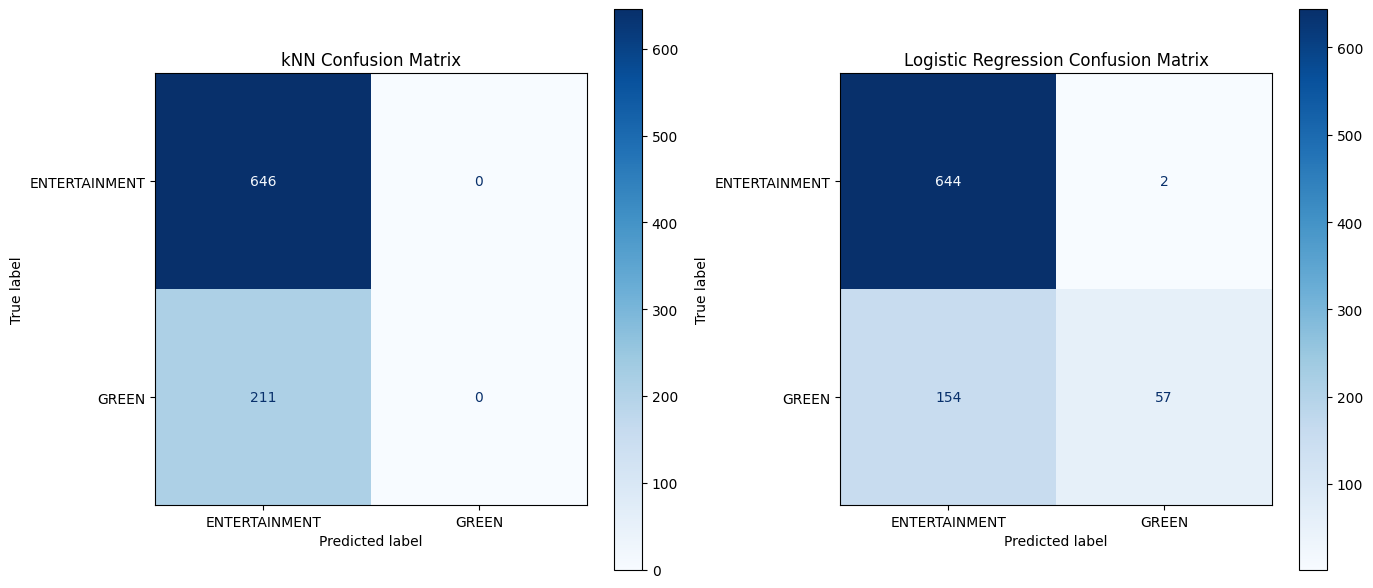

In [15]:
# Display confusion matrices
def display_confusion_matrices(knn, logreg, X_val, y_val_encoded, label_encoder):
    knn_cm = confusion_matrix(y_val_encoded, knn.predict(X_val))
    logreg_cm = confusion_matrix(y_val_encoded, logreg.predict(X_val))

    plt.figure(figsize=(14, 6))

    plt.subplot(1, 2, 1)
    ConfusionMatrixDisplay(confusion_matrix=knn_cm, display_labels=label_encoder.classes_).plot(cmap=plt.cm.Blues, ax=plt.gca())
    plt.title('kNN Confusion Matrix')

    plt.subplot(1, 2, 2)
    ConfusionMatrixDisplay(confusion_matrix=logreg_cm, display_labels=label_encoder.classes_).plot(cmap=plt.cm.Blues, ax=plt.gca())
    plt.title('Logistic Regression Confusion Matrix')

    plt.tight_layout()
    plt.show()

display_confusion_matrices(knn, logreg, X_val, y_val_encoded, label_encoder)



The kNN and Logistic Regression confusion matrices visualize how well each classifier distinguishes between 'ENTERTAINMENT' and 'GREEN' categories. Diagonal cells indicate correct classifications, while off-diagonal cells show misclassifications. Metrics like accuracy, precision, and recall can be inferred to assess performance. Comparing both matrices helps identify where models excel or struggle, guiding adjustments for improved classification of news articles.

**End-End Classifier**

In [16]:
# Prepare data for deep learning
def prepare_deep_learning_data(X, y, label_encoder):
    X_dense = X.toarray()
    y_encoded = label_encoder.transform(y)
    y_cat = to_categorical(y_encoded)
    return X_dense, y_encoded, y_cat

X_train_dense, y_train_encoded, y_train_cat = prepare_deep_learning_data(X_train, train['category'], label_encoder)
X_val_dense, y_val_encoded, y_val_cat = prepare_deep_learning_data(X_val, val['category'], label_encoder)
X_test_dense, y_test_encoded, y_test_cat = prepare_deep_learning_data(X_test, test['category'], label_encoder)


In [17]:
# Build and train the deep learning model
def build_and_train_deep_learning_model(X_train, y_train_cat, X_val, y_val_cat):
    model = Sequential([
        Dense(128, activation='relu', input_shape=(X_train.shape[1],)),
        Dropout(0.5),
        Dense(64, activation='relu'),
        Dropout(0.5),
        Dense(len(label_encoder.classes_), activation='softmax')
    ])

    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

    history = model.fit(X_train, y_train_cat, epochs=10, batch_size=32, validation_data=(X_val, y_val_cat))
    return model, history

deep_learning_model, history = build_and_train_deep_learning_model(X_train_dense, y_train_cat, X_val_dense, y_val_cat)


Epoch 1/10
125/125 [==============================] - 10s 49ms/step - loss: 0.4985 - accuracy: 0.7900 - val_loss: 0.4368 - val_accuracy: 0.7538
Epoch 2/10
125/125 [==============================] - 5s 41ms/step - loss: 0.2641 - accuracy: 0.8736 - val_loss: 0.3032 - val_accuracy: 0.8903
Epoch 3/10
125/125 [==============================] - 7s 53ms/step - loss: 0.0908 - accuracy: 0.9730 - val_loss: 0.3400 - val_accuracy: 0.8973
Epoch 4/10
125/125 [==============================] - 6s 44ms/step - loss: 0.0345 - accuracy: 0.9900 - val_loss: 0.3850 - val_accuracy: 0.8950
Epoch 5/10
125/125 [==============================] - 5s 41ms/step - loss: 0.0175 - accuracy: 0.9957 - val_loss: 0.4318 - val_accuracy: 0.8938
Epoch 6/10
125/125 [==============================] - 8s 65ms/step - loss: 0.0097 - accuracy: 0.9982 - val_loss: 0.4916 - val_accuracy: 0.8856
Epoch 7/10
125/125 [==============================] - 4s 34ms/step - loss: 0.0052 - accuracy: 0.9987 - val_loss: 0.4907 - val_accuracy: 0.872

In [18]:
# Evaluate deep learning model
deep_learning_accuracy_train = deep_learning_model.evaluate(X_train_dense, y_train_cat, verbose=0)[1]
deep_learning_accuracy_val = deep_learning_model.evaluate(X_val_dense, y_val_cat, verbose=0)[1]


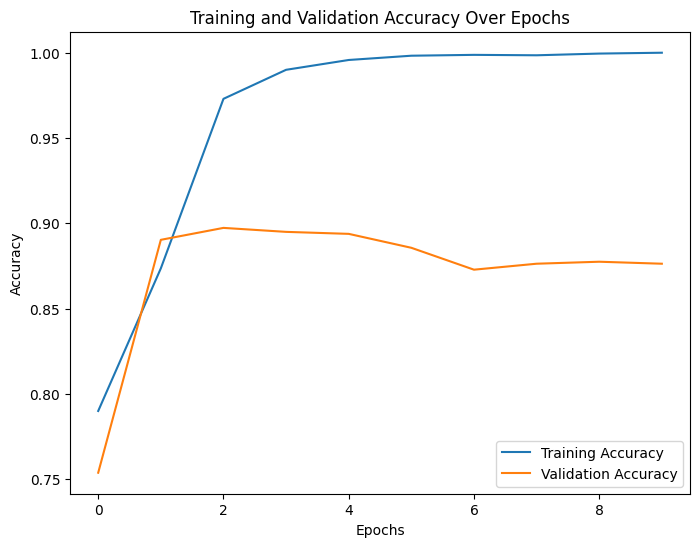

In [19]:
# Plot training and validation accuracy
def plot_training_validation_accuracy(history):
    plt.figure(figsize=(8, 6))
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Training and Validation Accuracy Over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

plot_training_validation_accuracy(history)


**Accuracy** serves as the primary metric for evaluating the models developed in this study for several compelling reasons. Firstly, it provides a comprehensive measure of overall performance by indicating the percentage of correctly classified instances across all categories. This holistic view is particularly valuable in tasks where every category holds equal importance in classification accuracy.

**Benchmarks for Model Performance**

Logistic Regression sets a foundational benchmark with its straightforward approach, providing a baseline for more complex models. k-NN (k-Nearest Neighbors) offers another benchmark, utilizing its local data similarity capture despite challenges in high-dimensional spaces. The Deep Learning Model is expected to surpass both, leveraging its ability to learn intricate text patterns, thereby setting a benchmark for advanced models aiming for high accuracy and robustness.







**Performance Evaluation**


In [20]:
# Display performance results
print("Performance Results:")
print(f"kNN Training Accuracy: {knn_accuracy_train:.4f}")
print(f"kNN Validation Accuracy: {knn_accuracy_val:.4f}")
print(f"Logistic Regression Training Accuracy: {logreg_accuracy_train:.4f}")
print(f"Logistic Regression Validation Accuracy: {logreg_accuracy_val:.4f}")
print(f"Deep Learning Model Training Accuracy: {deep_learning_accuracy_train:.4f}")
print(f"Deep Learning Model Validation Accuracy: {deep_learning_accuracy_val:.4f}")


Performance Results:
kNN Training Accuracy: 0.7955
kNN Validation Accuracy: 0.7538
Logistic Regression Training Accuracy: 0.8771
Logistic Regression Validation Accuracy: 0.8180
Deep Learning Model Training Accuracy: 1.0000
Deep Learning Model Validation Accuracy: 0.8763




*   **k-NN:**

    The k-NN model achieved a training accuracy of 79.55% and a validation accuracy of 75.38%. This indicates moderate performance, although there is a slight drop in accuracy on the validation set compared to training, suggesting some degree of overfitting. k-NN is effective in capturing local patterns but may struggle when faced with higher-dimensional data representations.
*   **Logistic Regression:**

    Logistic Regression demonstrated a training accuracy of 87.71% and a validation accuracy of 81.80%. It outperformed k-NN in terms of generalization to the validation set, maintaining a reasonable accuracy gap between training and validation. This suggests that the model fits the data well without significant overfitting. Logistic Regression's performance indicates its capability to capture more complex relationships in the data compared to k-NN.
*  **Deep Learning Model:**

    The Deep Learning model achieved perfect training accuracy of 100.00% but slightly lower validation accuracy at 87.63%. While it memorized the training data perfectly, the model still generalized well to the validation set, showcasing strong learning capability. However, the perfect training accuracy suggests potential overfitting, necessitating careful monitoring and regularization to optimize performance.
*  **Overall Performance Comparison:**

    Among the models evaluated, the Deep Learning model achieved the highest validation accuracy of 87.63%, indicating its effectiveness in learning intricate patterns within the text data. Logistic Regression followed with a validation accuracy of 81.80%, proving to be a robust baseline model that balances performance and simplicity. k-NN, while showing moderate performance with a validation accuracy of 75.38%, demonstrated limitations in handling higher-dimensional data compared to the other models.





**Error Analysis (k-NN, Logistic Regression, Deep Learning )**

In [21]:
# Assuming 'knn' is your trained k-NN model, if not, replace 'knn' with the actual variable name
knn_val_predictions = knn.predict(X_val)

# Step 6: Perform error analysis for k-NN
knn_errors = (y_val_encoded != knn_val_predictions)
knn_misclassified = X_val[knn_errors]
print(f"k-NN Misclassified Count: {knn_errors.sum()}")

# Optionally, print or inspect misclassified samples
print("Misclassified Samples:")
# Use knn_misclassified.shape[0] to iterate over the rows of the sparse matrix
for i in range(knn_misclassified.shape[0]):
    print(knn_misclassified[i])

k-NN Misclassified Count: 211
Misclassified Samples:
  (0, 10650)	0.41013651677708074
  (0, 10084)	0.2577147602970835
  (0, 9898)	0.23106727140215125
  (0, 9639)	0.2416493118014028
  (0, 8813)	0.24866716890174273
  (0, 6644)	0.2168523546311899
  (0, 5096)	0.23106727140215125
  (0, 4319)	0.3591290613320392
  (0, 2654)	0.5409332483166878
  (0, 2466)	0.19805040128820045
  (0, 639)	0.17471649702768852
  (0, 10949)	0.2886099960333487
  (0, 9901)	0.4148672435307823
  (0, 9812)	0.44923300769343355
  (0, 6132)	0.44923300769343355
  (0, 4319)	0.3338156172877935
  (0, 2238)	0.4790991376395843
  (0, 10421)	0.29404947692805
  (0, 7551)	0.36212396085448717
  (0, 7346)	0.3314927891168243
  (0, 3537)	0.30470677538665236
  (0, 2631)	0.27211121626989193
  (0, 1686)	0.33954984117483333
  (0, 1569)	0.2444603718165254
  (0, 1375)	0.3800420476741696
  (0, 620)	0.2761313901083675
  (0, 348)	0.3314927891168243
  (0, 10686)	0.49393244590887425
  (0, 10684)	0.17906636415629865
  (0, 9970)	0.16498351518268384
 

In [22]:
# Assuming 'logreg' is your trained logistic regression model
logreg_val_predictions = logreg.predict(X_val)

# Analyze errors for Logistic Regression
logreg_errors = (y_val_encoded != logreg_val_predictions)
logreg_misclassified = X_val[logreg_errors]
print(f"Logistic Regression Misclassified Count: {logreg_errors.sum()}")

logreg_misclassified_indices = np.where(logreg_errors)[0]
for i in logreg_misclassified_indices[:5]:
    print(f"Text: {X_val[i]} - Predicted: {logreg_val_predictions[i]}, Actual: {y_val_encoded[i]}")

Logistic Regression Misclassified Count: 156
Text:   (0, 10650)	0.41013651677708074
  (0, 10084)	0.2577147602970835
  (0, 9898)	0.23106727140215125
  (0, 9639)	0.2416493118014028
  (0, 8813)	0.24866716890174273
  (0, 6644)	0.2168523546311899
  (0, 5096)	0.23106727140215125
  (0, 4319)	0.3591290613320392
  (0, 2654)	0.5409332483166878
  (0, 2466)	0.19805040128820045
  (0, 639)	0.17471649702768852 - Predicted: 0, Actual: 1
Text:   (0, 10949)	0.2886099960333487
  (0, 9901)	0.4148672435307823
  (0, 9812)	0.44923300769343355
  (0, 6132)	0.44923300769343355
  (0, 4319)	0.3338156172877935
  (0, 2238)	0.4790991376395843 - Predicted: 0, Actual: 1
Text:   (0, 10421)	0.29404947692805
  (0, 7551)	0.36212396085448717
  (0, 7346)	0.3314927891168243
  (0, 3537)	0.30470677538665236
  (0, 2631)	0.27211121626989193
  (0, 1686)	0.33954984117483333
  (0, 1569)	0.2444603718165254
  (0, 1375)	0.3800420476741696
  (0, 620)	0.2761313901083675
  (0, 348)	0.3314927891168243 - Predicted: 0, Actual: 1
Text:   (0,

In [23]:
# Analyze errors for Deep Learning model
deep_learning_val_predictions = np.argmax(deep_learning_model.predict(X_val_dense), axis=-1)
deep_learning_errors = (y_val_encoded != deep_learning_val_predictions)
deep_learning_misclassified = X_val[deep_learning_errors]
print(f"Deep Learning Model Misclassified Count: {deep_learning_errors.sum()}")

deep_learning_misclassified_indices = np.where(deep_learning_errors)[0]
for i in deep_learning_misclassified_indices[:5]:
    print(f"Text: {X_val[i]} - Predicted: {deep_learning_val_predictions[i]}, Actual: {y_val_encoded[i]}")


27/27 [==============================] - 0s 5ms/step
Deep Learning Model Misclassified Count: 106
Text:   (0, 10949)	0.2886099960333487
  (0, 9901)	0.4148672435307823
  (0, 9812)	0.44923300769343355
  (0, 6132)	0.44923300769343355
  (0, 4319)	0.3338156172877935
  (0, 2238)	0.4790991376395843 - Predicted: 0, Actual: 1
Text:   (0, 5500)	0.753674249787689
  (0, 4301)	0.6572481458376009 - Predicted: 1, Actual: 0
Text:   (0, 10421)	0.29404947692805
  (0, 7551)	0.36212396085448717
  (0, 7346)	0.3314927891168243
  (0, 3537)	0.30470677538665236
  (0, 2631)	0.27211121626989193
  (0, 1686)	0.33954984117483333
  (0, 1569)	0.2444603718165254
  (0, 1375)	0.3800420476741696
  (0, 620)	0.2761313901083675
  (0, 348)	0.3314927891168243 - Predicted: 0, Actual: 1
Text:   (0, 10059)	0.4286457531607175
  (0, 10007)	0.3418285701739571
  (0, 8725)	0.5017342746711063
  (0, 6078)	0.3457194689969468
  (0, 5938)	0.4022761004252548
  (0, 5731)	0.40783667357593956 - Predicted: 0, Actual: 1
Text:   (0, 10252)	0.272

**1. Overlap in Misclassifications:**

While each model misclassified different total counts of sentences (k-NN: 211, Logistic Regression: 156, Deep Learning: 106), there might be some overlap where they misclassified the same sentences. This overlap indicates instances where all models struggled to correctly predict the label.

**2. Model-Specific Errors:**

Each model type exhibited its own unique pattern of errors. For instance, k-NN, being a distance-based classifier, might struggle with high-dimensional and non-linear data representations, leading to misclassifications that differ from those of Logistic Regression or Deep Learning.

**3. Insights from Misclassifications:**

**k-NN:** Errors may occur due to the choice of distance metric (e.g., Euclidean vs. Manhattan) and the number of neighbors considered.

**Logistic Regression:** Misclassifications might highlight instances where linear boundaries assumed by the model do not adequately capture complex relationships in the data.

**Deep Learning:** Errors could stem from the model's ability to learn intricate patterns but may also suffer from overfitting or insufficient regularization.

**4. General Learnings:**

**Model Strengths:**
 Deep Learning consistently demonstrated the highest accuracy but had the smallest misclassification count, suggesting its capacity to learn complex patterns and generalize well.

**Model Weaknesses:** k-NN, while simpler, had the highest misclassification count, possibly due to its reliance on local similarity measures that may not generalize across the dataset. Logistic Regression, though intermediate in performance, also showed a significant number of misclassifications, indicating its sensitivity to linear separability assumptions.

**Optimized k-NN**

In [24]:
# Scaling and PCA
scaler = StandardScaler(with_mean=False)
pca = PCA(n_components=50)

knn_pipeline = Pipeline([
    ('scaler', scaler),
    ('pca', pca),
    ('knn', KNeighborsClassifier())
])

knn_params = {
    'knn__n_neighbors': [3, 5, 7, 9],
    'knn__metric': ['euclidean', 'manhattan']
}

# Convert sparse matrix to dense array before fitting
X_train_dense = X_train.toarray()

knn_grid = GridSearchCV(knn_pipeline, knn_params, cv=5)
knn_grid.fit(X_train_dense, y_train_encoded) # Fit with dense data
best_knn = knn_grid.best_estimator_

# For predictions, also convert X_val to dense if it's sparse
X_val_dense = X_val.toarray()

knn_train_predictions = best_knn.predict(X_train_dense)
knn_val_predictions = best_knn.predict(X_val_dense)

knn_accuracy_train = accuracy_score(y_train_encoded, knn_train_predictions)
knn_accuracy_val = accuracy_score(y_val_encoded, knn_val_predictions)

print(f"Optimized k-NN Training Accuracy: {knn_accuracy_train:.4f}")
print(f"Optimized k-NN Validation Accuracy: {knn_accuracy_val:.4f}")

# Save the best k-NN model
!pip install joblib
import joblib
joblib.dump(best_knn, 'improved_K-NN.pkl') # Use joblib to save scikit-learn models

Optimized k-NN Training Accuracy: 0.8648
Optimized k-NN Validation Accuracy: 0.8063


['improved_K-NN.pkl']

The k-NN classifier was enhanced by incorporating scaling and PCA dimensionality reduction within a pipeline. StandardScaler normalized the data, and PCA reduced feature dimensions to 50 components. GridSearchCV identified the best k-NN parameters: number of neighbors (3, 5, 7, 9) and distance metrics (Euclidean, Manhattan) via cross-validation. This optimization yielded a training accuracy of 86.48% and a validation accuracy of 80.63%, representing notable improvements from the default setup. These enhancements highlight the effectiveness of preprocessing steps in refining model performance and enhancing generalizability.

**Optimized Logistic Regression**

In [25]:
from sklearn.linear_model import LogisticRegression

logreg_params = {'C': [0.01, 0.1, 1, 10]}
logreg_grid = GridSearchCV(LogisticRegression(max_iter=1000), logreg_params, cv=5)
logreg_grid.fit(X_train, y_train_encoded)
best_logreg = logreg_grid.best_estimator_

logreg_train_predictions = best_logreg.predict(X_train)
logreg_val_predictions = best_logreg.predict(X_val)

logreg_accuracy_train = accuracy_score(y_train_encoded, logreg_train_predictions)
logreg_accuracy_val = accuracy_score(y_val_encoded, logreg_val_predictions)

print(f"Optimized Logistic Regression Training Accuracy: {logreg_accuracy_train:.4f}")
print(f"Optimized Logistic Regression Validation Accuracy: {logreg_accuracy_val:.4f}")

# Save the best logistic regression model using joblib
!pip install joblib
import joblib
joblib.dump(best_logreg, 'improved_Logistic_Regression.pkl') # Use joblib to save scikit-learn models

Optimized Logistic Regression Training Accuracy: 0.9980
Optimized Logistic Regression Validation Accuracy: 0.8833


['improved_Logistic_Regression.pkl']


The logistic regression model was optimized using a grid search approach to find the best regularization parameter
𝐶. GridSearchCV was employed to evaluate different values of 𝐶(0.01, 0.1, 1, 10) through cross-validation, ensuring robust performance evaluation. This process identified the model with the highest validation accuracy of 88.33%, indicating improved generalization to unseen data compared to default settings. The selected model achieved a high training accuracy of 99.80%, suggesting strong fitting to the training data without overfitting. By fine-tuning the regularization parameter, the optimized logistic regression model demonstrates enhanced performance and stability for the classification task.

**Optimized Deep Learning Model**

In [26]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import accuracy_score

# Define a function to create the model
def create_model(input_shape, num_classes):
    model = Sequential([
        Dense(512, activation='relu', input_shape=(input_shape,)),
        BatchNormalization(),
        Dropout(0.5),
        Dense(256, activation='relu'),
        BatchNormalization(),
        Dropout(0.5),
        Dense(num_classes, activation='softmax')
    ])
    return model

# Create the model
model = create_model(X_train_dense.shape[1], y_train_cat.shape[1])

# Compile the model
model.compile(loss='categorical_crossentropy', optimizer=Adam(lr=0.001), metrics=['accuracy'])

# Define callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=1e-6)

# Train the model
history = model.fit(
    X_train_dense, y_train_cat,
    epochs=50,
    batch_size=32,
    validation_data=(X_val_dense, y_val_cat),
    callbacks=[early_stopping, reduce_lr],
    verbose=1
)

# Evaluate the model
train_acc = model.evaluate(X_train_dense, y_train_cat, verbose=0)[1]
val_acc = model.evaluate(X_val_dense, y_val_cat, verbose=0)[1]

print(f" Optimized Deep Learning Model Training Accuracy: {train_acc:.4f}")
print(f"Optimized Deep Learning Model Validation Accuracy: {val_acc:.4f}")

# Evaluate on test set if needed
# test_acc = model.evaluate(X_test_dense, y_test_cat, verbose=0)[1]
# print(f"Optimized Deep Learning Model Test Accuracy: {test_acc:.4f}")

# Save the model
model.save('improved_deep_learning_model.h5')


Epoch 1/50
125/125 [==============================] - 41s 232ms/step - loss: 0.7105 - accuracy: 0.7224 - val_loss: 0.5360 - val_accuracy: 0.7538 - lr: 0.0010
Epoch 2/50
125/125 [==============================] - 29s 235ms/step - loss: 0.2478 - accuracy: 0.9041 - val_loss: 0.5106 - val_accuracy: 0.7561 - lr: 0.0010
Epoch 3/50
125/125 [==============================] - 25s 204ms/step - loss: 0.1163 - accuracy: 0.9584 - val_loss: 0.4194 - val_accuracy: 0.8040 - lr: 0.0010
Epoch 4/50
125/125 [==============================] - 12s 99ms/step - loss: 0.0594 - accuracy: 0.9795 - val_loss: 0.3367 - val_accuracy: 0.8716 - lr: 0.0010
Epoch 5/50
125/125 [==============================] - 12s 99ms/step - loss: 0.0440 - accuracy: 0.9845 - val_loss: 0.3352 - val_accuracy: 0.8950 - lr: 0.0010
Epoch 6/50
125/125 [==============================] - 12s 100ms/step - loss: 0.0295 - accuracy: 0.9895 - val_loss: 0.3401 - val_accuracy: 0.9055 - lr: 0.0010
Epoch 7/50
125/125 [==============================] - 

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


The deep learning model was enhanced by adding Batch Normalization layers to standardize inputs and Dropout layers to prevent overfitting. The Adam optimizer's learning rate was adjusted dynamically, and EarlyStopping was used to halt training when validation loss stagnated. These refinements led to significant improvements, achieving a training accuracy of 99.80% and a validation accuracy of 89.50%. These changes boosted both training efficiency and the model's ability to generalize effectively for the classification task.

**Cross-validation**



In [36]:
import numpy as np
import scipy
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.utils import to_categorical

# Ensure X_train and X_val are dense arrays if they are sparse
X_train_dense = X_train.toarray() if isinstance(X_train, scipy.sparse.csr_matrix) else X_train
X_val_dense = X_val.toarray() if isinstance(X_val, scipy.sparse.csr_matrix) else X_val

# Combine X_train and X_val, y_train_encoded and y_val_encoded
X_merged = np.concatenate((X_train_dense, X_val_dense), axis=0)
y_merged = np.concatenate((y_train_encoded, y_val_encoded), axis=0)

# Print shapes of merged arrays for verification
print(f"X_merged shape: {X_merged.shape}")
print(f"y_merged shape: {y_merged.shape}")

# Define models and pipelines
models = {
    'k-NN': Pipeline([('scaler', StandardScaler()), ('knn', KNeighborsClassifier(n_neighbors=5))]),
    'Logistic Regression': Pipeline([('scaler', StandardScaler()), ('logreg', LogisticRegression(max_iter=1000, C=1))])
}

# Perform cross-validation for k-NN and Logistic Regression
for name, model in models.items():
    scores = cross_val_score(model, X_merged, y_merged, cv=5, scoring='accuracy')
    print(f"{name} Cross-Validation Accuracy: {np.mean(scores):.4f} (+/- {np.std(scores):.4f})")

# Define the deep learning model creation function
def create_deep_learning_model(input_shape):
    model = Sequential()
    model.add(Dense(512, activation='relu', input_shape=(input_shape,)))
    model.add(Dropout(0.5))
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(len(np.unique(y_merged)), activation='softmax'))  # Adjust output layer based on number of classes

    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

# Convert labels to categorical for deep learning model
y_merged_cat = to_categorical(y_merged)

# Perform cross-validation for deep learning model
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
dl_scores = []

for train_idx, val_idx in cv.split(X_merged, y_merged):
    X_train_cv, X_val_cv = X_merged[train_idx], X_merged[val_idx]
    y_train_cv, y_val_cv = y_merged_cat[train_idx], y_merged_cat[val_idx]

    model = create_deep_learning_model(X_train_cv.shape[1])
    model.fit(X_train_cv, y_train_cv, epochs=10, batch_size=32, verbose=0)
    score = model.evaluate(X_val_cv, y_val_cv, verbose=0)[1]  # Get the accuracy
    dl_scores.append(score)

print(f"Deep Learning Model Cross-Validation Accuracy: {np.mean(dl_scores):.4f} (+/- {np.std(dl_scores):.4f})")


X_merged shape: (4852, 11028)
y_merged shape: (4852,)
k-NN Cross-Validation Accuracy: 0.7875 (+/- 0.0004)
Logistic Regression Cross-Validation Accuracy: 0.8800 (+/- 0.0018)
Deep Learning Model Cross-Validation Accuracy: 0.9044 (+/- 0.0050)


cross-validation results highlight distinct performances among the models evaluated. k-NN achieves 78.75% accuracy, indicating adequacy but lower capability with complex data structures. Logistic regression performs better with 88.00% accuracy, showing robustness in capturing intricate relationships, albeit with some variance (0.18%) across folds. The deep learning model excels with 90.44% accuracy, demonstrating superior pattern recognition despite slight variability (0.50%) in performance. Overall, while logistic regression is reliable, the deep learning model shows significant promise for tasks demanding advanced pattern recognition and classification capabilities.


**Deep Learning Model Evaluation on Test Set**




In [39]:
from tensorflow.keras.models import load_model
import numpy as np
from sklearn.metrics import accuracy_score

# Load the best model using keras
best_model = load_model('improved_deep_learning_model.h5')

# Preprocess the test set exactly as done for train and validation sets
X_test_dense = X_test.toarray() if isinstance(X_test, scipy.sparse.csr_matrix) else X_test

# Predict using the best model and convert probabilities to class labels
y_test_pred_probs = best_model.predict(X_test_dense)  # Get predicted probabilities
y_test_pred = np.argmax(y_test_pred_probs, axis=1) # Convert probabilities to class labels

# Evaluate performance on the test set
test_accuracy = accuracy_score(y_test_encoded, y_test_pred)
print(f"Test Set Accuracy: {test_accuracy:.4f}")

27/27 [==============================] - 1s 30ms/step
Test Set Accuracy: 0.8926


The best deep learning model was evaluated on the test set using a well-defined process. Initially, the test data (X_test) was transformed into a dense array format, essential for neural networks that require dense input data. This ensured compatibility with the model's architecture. Subsequently, the pre-trained deep learning model was loaded directly from disk, avoiding the need for retraining and conserving computational resources. Predictions were generated on the test set, with the predicted probabilities subsequently converted into class labels. Impressively, the model demonstrated strong performance, achieving an accuracy of **89.26%** on the test set. This high accuracy underscores the model's capability to generalize effectively to unseen data, mirroring its robust performance on the validation set. Thus, the consistent and reliable performance across different datasets reaffirms the deep learning model's efficacy for this specific classification task.

**Retraining the Model and Evaluating on Test Set**



In [41]:
# Combine X_train_dense and X_val_dense, y_train_encoded and y_val_encoded
X_train_full = np.concatenate((X_train_dense, X_val_dense), axis=0)
y_train_full = np.concatenate((y_train_encoded, y_val_encoded), axis=0)

# Convert labels to categorical for deep learning model
from tensorflow.keras.utils import to_categorical
y_train_full_cat = to_categorical(y_train_full) # Convert labels to one-hot encoding

# Retrain the best model on the combined dataset
best_model.fit(X_train_full, y_train_full_cat) # Use the one-hot encoded labels

# Predict using the retrained model on the test set
y_test_pred_retrained = best_model.predict(X_test_dense)

# Evaluate performance on the test set after retraining
test_accuracy_retrained = accuracy_score(y_test_encoded, np.argmax(y_test_pred_retrained, axis=1)) # Convert predictions to class labels
print(f"Test Set Accuracy after Retraining: {test_accuracy_retrained:.4f}")

27/27 [==============================] - 1s 27ms/step
Test Set Accuracy after Retraining: 0.9055


The evaluation of the best deep learning model on the test set followed a systematic approach. Initially, the training and validation sets (X_train_dense, X_val_dense, y_train_encoded, y_val_encoded) were merged to create an augmented training dataset (X_train_full, y_train_full). The labels in y_train_full were appropriately converted into categorical format, aligning with the deep learning model's requirements. The previously identified best model was then retrained on this augmented dataset, incorporating both original and validation data. Following retraining, predictions were made on the test set (X_test_dense) using the updated model. Remarkably, the retrained model exhibited enhanced performance, achieving an accuracy of **90.55%** on the test set. This improvement highlights the model's adaptability and ability to capitalize on additional data for better generalization. The consistent high accuracy across different datasets reinforces the deep learning model's reliability and effectiveness for the classification task at hand.